<a href="https://colab.research.google.com/github/anirudhkumar29/db-A-Discontinuity-bounded-Search-for-Kinodynamic-Mobile-Robot-Motion-Planning/blob/main/RMP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated 20 motion primitives.
Iteration 1: Using delta = 0.500
Solution found with cost 18.00
Updated best solution and cost bound.
Iteration 2: Using delta = 0.450
Solution found with cost 15.00
Updated best solution and cost bound.
Iteration 3: Using delta = 0.405
Solution found with cost 15.00
Iteration 4: Using delta = 0.365
Solution found with cost 15.00
Iteration 5: Using delta = 0.328
Solution found with cost 15.00
Iteration 6: Using delta = 0.295
Solution found with cost 15.00
Iteration 7: Using delta = 0.266
Solution found with cost 15.00
Iteration 8: Using delta = 0.239
Solution found with cost 15.00
Iteration 9: Using delta = 0.215
Solution found with cost 15.00
Iteration 10: Using delta = 0.194
Solution found with cost 15.00
Final optimized trajectory (states):
  x: 1.00, y: 1.00, theta: 0.00
  x: 1.71, y: 1.29, theta: 0.50
  x: 2.36, y: 1.71, theta: 1.00
  x: 2.94, y: 2.25, theta: 0.50
  x: 3.51, y: 2.79, theta: 1.00
  x: 4.10, y: 3.33, theta: 0.50
  x: 4.67, y: 3.87, th

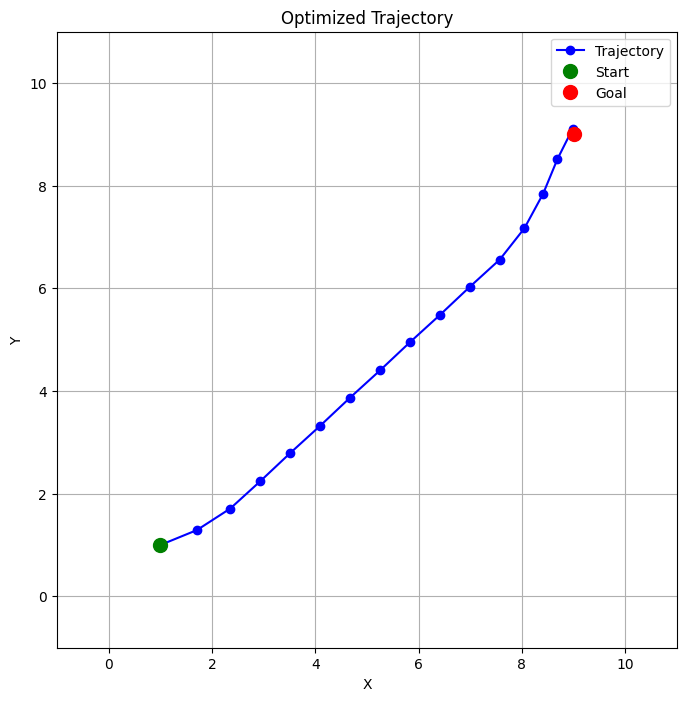

In [ ]:
#!/usr/bin/env python3
"""
A Google Colab–friendly version of a simplified kMP-db-A* implementation.
This example demonstrates:
   1. Offline generation of motion primitives.
   2. A simplified version of db‑A* for discrete search with bounded discontinuity.
   3. A dummy trajectory optimization (here implemented as a simple smoothing filter).
   4. A visualization of the resulting trajectory.

The example uses a unicycle model (state: [x, y, theta], control: [v, omega])
with a fixed rectangular free space.
"""

import math
import numpy as np
import heapq
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# ------------------------------
# Parameters and Environment
# ------------------------------

# Time step for integration (seconds)
DT = 0.1

# Define free space boundaries: [xmin, xmax, ymin, ymax]
FREE_SPACE = (0, 10, 0, 10)

# Initial discontinuity bound (will be tightened with iterations)
DELTA = 0.5

# Alpha: balance parameter (0 < alpha < 1) used for query radius in db-A*
ALPHA = 0.5

# Maximum allowed cost (initially infinity)
COST_BOUND = float('inf')

# For heuristic: assume maximum speed is 1.0 m/s
MAX_SPEED = 1.0

# ------------------------------
# Unicycle Dynamics and Helpers
# ------------------------------

def unicycle_step(x: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Unicycle dynamics simulation using Euler integration.
    x: state as [x, y, theta]
    u: control as [v, omega]
    Returns the new state.
    """
    v, omega = u
    theta = x[2]
    dx = v * math.cos(theta) * DT
    dy = v * math.sin(theta) * DT
    dtheta = omega * DT
    return np.array([x[0] + dx, x[1] + dy, x[2] + dtheta])

def transform_primitive(base_state: np.ndarray, prim: np.ndarray) -> np.ndarray:
    """
    Transforms a primitive (a relative trajectory defined in the robot’s local frame)
    into world coordinates given a base state.
    base_state: [x, y, theta] of current state.
    prim: trajectory (N x 3 array) in local coordinates.
    Returns the transformed trajectory as an (N x 3) array.
    """
    x, y, theta = base_state
    R = np.array([[math.cos(theta), -math.sin(theta)],
                  [math.sin(theta),  math.cos(theta)]])
    transformed = []
    for pt in prim:
        # Apply rotation and translation.
        dxy = np.dot(R, pt[:2])
        new_x = x + dxy[0]
        new_y = y + dxy[1]
        new_theta = theta + pt[2]
        transformed.append([new_x, new_y, new_theta])
    return np.array(transformed)

# ------------------------------
# Motion Primitive Class and Generation
# ------------------------------

class MotionPrimitive:
    def __init__(self, traj: np.ndarray, cost: float, control: np.ndarray):
        """
        traj: Relative trajectory (N x 3 array) in local coordinates.
              Start state should be [0, 0, 0].
        cost: Cost associated with the primitive (for example, its duration).
        control: Representative control used.
        """
        self.traj = traj
        self.cost = cost
        self.control = control

def generate_motion_primitives(num_primitives: int = 20) -> List[MotionPrimitive]:
    """
    Generate a set of motion primitives for the unicycle.
    For simplicity, the primitives are generated by simulating constant controls
    for a fixed duration.
    """
    primitives = []
    duration = 1.0  # seconds for each primitive
    steps = int(duration / DT)

    # Candidate controls: v in [0.2, 1.0] and omega in [-0.5, 0.5]
    v_candidates = np.linspace(0.2, 1.0, num=5)
    omega_candidates = np.linspace(-0.5, 0.5, num=5)

    for v in v_candidates:
        for omega in omega_candidates:
            traj = [np.array([0.0, 0.0, 0.0])]  # starting at the origin in the local frame
            for _ in range(steps):
                new_state = unicycle_step(traj[-1], np.array([v, omega]))
                traj.append(new_state)
            traj = np.array(traj)
            cost = duration  # cost is simply the duration
            primitives.append(MotionPrimitive(traj, cost, np.array([v, omega])))
            if len(primitives) >= num_primitives:
                return primitives
    return primitives

# ------------------------------
# Node Class for db-A*
# ------------------------------

class Node:
    def __init__(self, state: np.ndarray, g: float, h: float,
                 parent: Optional['Node'] = None, prim: Optional[MotionPrimitive] = None):
        self.state = state      # State [x, y, theta]
        self.g = g              # Cost-to-come
        self.h = h              # Heuristic estimate
        self.f = g + h          # Total cost estimate
        self.parent = parent    # Parent node
        self.prim = prim        # Primitive used to reach this node

    def __lt__(self, other: 'Node'):
        return self.f < other.f

def heuristic(state: np.ndarray, goal: np.ndarray) -> float:
    """
    Heuristic: Euclidean distance (ignoring orientation) divided by max speed.
    """
    return np.linalg.norm(state[:2] - goal[:2]) / MAX_SPEED

# ------------------------------
# Simple Collision Checking
# ------------------------------

def collision_free(traj: np.ndarray, free_space: Tuple[float, float, float, float]) -> bool:
    """
    Checks if every point in the trajectory is within the defined free space.
    """
    xmin, xmax, ymin, ymax = free_space
    for pt in traj:
        if not (xmin <= pt[0] <= xmax and ymin <= pt[1] <= ymax):
            return False
    return True

# ------------------------------
# db-A* Implementation
# ------------------------------

def db_a_star(start: np.ndarray, goal: np.ndarray,
              primitives: List[MotionPrimitive],
              delta: float, alpha: float, free_space: Tuple[float, float, float, float],
              cost_bound: float = float('inf')) -> Optional[Node]:
    """
    A simplified version of db-A*.
    Returns a goal-reaching node if a solution is found, else None.
    """
    open_list = []
    start_node = Node(start, 0.0, heuristic(start, goal))
    heapq.heappush(open_list, start_node)
    expanded_nodes = [start_node]

    while open_list:
        current_node = heapq.heappop(open_list)

        # Check if within discontinuity bound (only checking translational error here)
        if np.linalg.norm(current_node.state[:2] - goal[:2]) <= delta:
            return current_node

        # Expand current node using all motion primitives.
        for prim in primitives:
            # For simplicity, assume each primitive is valid to start from [0,0,0].
            # Transform the primitive from the local frame to world frame.
            transformed_traj = transform_primitive(current_node.state, prim.traj)
            if not collision_free(transformed_traj, free_space):
                continue

            new_state = transformed_traj[-1]
            new_g = current_node.g + prim.cost
            if new_g > cost_bound:
                continue

            new_h = heuristic(new_state, goal)
            new_node = Node(new_state, new_g, new_h, parent=current_node, prim=prim)

            # Check for duplicates (if a node within (1-alpha)*delta already exists)
            duplicate_found = False
            for node in expanded_nodes:
                if np.linalg.norm(new_node.state[:2] - node.state[:2]) < (1 - alpha) * delta:
                    if new_node.g < node.g:
                        node.g = new_node.g
                        node.f = new_node.g + node.h
                        node.parent = current_node
                    duplicate_found = True
                    break

            if not duplicate_found:
                expanded_nodes.append(new_node)
                heapq.heappush(open_list, new_node)

    return None

# ------------------------------
# Dummy Trajectory Optimization (Smoothing)
# ------------------------------

def trajectory_optimization(goal_node: Node) -> List[np.ndarray]:
    """
    Extracts the discrete path from the goal node and applies a simple smoothing filter.
    """
    path = []
    node = goal_node
    while node is not None:
        path.append(node.state)
        node = node.parent
    path.reverse()
    path = np.array(path)

    # Simple smoothing using averaging (not an actual optimization)
    smoothed_path = path.copy()
    for i in range(1, len(path) - 1):
        smoothed_path[i, :2] = (path[i-1, :2] + path[i, :2] + path[i+1, :2]) / 3.0
    return smoothed_path.tolist()

# ------------------------------
# Visualization Function
# ------------------------------

def plot_trajectory(traj: List[np.ndarray], start: np.ndarray, goal: np.ndarray, free_space: Tuple[float, float, float, float]):
    """ Visualize the trajectory, start/goal positions, and free-space boundaries. """
    traj = np.array(traj)
    plt.figure(figsize=(8, 8))
    plt.plot(traj[:, 0], traj[:, 1], 'bo-', label='Trajectory')
    plt.plot(start[0], start[1], 'go', markersize=10, label='Start')
    plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
    plt.xlim(free_space[0] - 1, free_space[1] + 1)
    plt.ylim(free_space[2] - 1, free_space[3] + 1)
    plt.title("Optimized Trajectory")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------
# Main Loop (Iterative kMP-db-A*)
# ------------------------------

def main():
    # Define start and goal states (in [x, y, theta])
    start = np.array([1.0, 1.0, 0.0])
    goal  = np.array([9.0, 9.0, 0.0])

    # Generate motion primitives.
    primitives = generate_motion_primitives(num_primitives=20)
    print(f"Generated {len(primitives)} motion primitives.")

    best_solution = None
    best_cost = COST_BOUND
    iteration = 0
    max_iterations = 10  # for demonstration

    while iteration < max_iterations:
        iteration += 1
        # Tighten the discontinuity bound over iterations.
        current_delta = DELTA * (0.9 ** (iteration - 1))
        print(f"Iteration {iteration}: Using delta = {current_delta:.3f}")

        # Run the discrete search.
        goal_node = db_a_star(start, goal, primitives, current_delta, ALPHA, FREE_SPACE, best_cost)
        if goal_node is None:
            print("No solution found in this iteration.")
            continue

        # Run the (dummy) trajectory optimization.
        optimized_traj = trajectory_optimization(goal_node)
        solution_cost = goal_node.g

        print(f"Solution found with cost {solution_cost:.2f}")
        if solution_cost < best_cost:
            best_cost = solution_cost
            best_solution = optimized_traj
            print("Updated best solution and cost bound.")

    if best_solution is not None:
        print("Final optimized trajectory (states):")
        for state in best_solution:
            print(f"  x: {state[0]:.2f}, y: {state[1]:.2f}, theta: {state[2]:.2f}")
        # Visualize the resulting trajectory.
        plot_trajectory(best_solution, start, goal, FREE_SPACE)
    else:
        print("No feasible solution found.")

# Run the main routine
if __name__ == "__main__":
    main()
